In [2]:
from torch import nn
from PIL import Image
from torchvision import transforms as T
import numpy as np
import torch

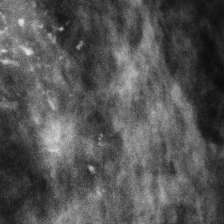

In [3]:
fn = '/fast/rsna-breast/topTilesRaw/0_7.653875350952148_1696728511_8_7.png'
pil = Image.open(fn)
pil

In [69]:
a=np.asarray(pil)
a.min(), a.mean(), a.max(), a.std()

(11, 83.99202806122449, 224, 35.889364616424196)

torch.Size([1, 224, 224]) tensor(-1.8275) tensor(-0.6825) tensor(1.5137)
torch.Size([1, 224, 224])
BW
(224, 224, 3) 0 86.88426737882654 255 uint8


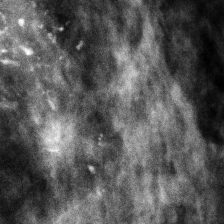

In [4]:

def backToPil(tensor):
    print(tensor.shape)
    if tensor.shape[0]==1:
        print('BW')
        tensor = torch.cat([tensor]*3)
    tensor = tensor.permute(1, 2, 0)

    i = tensor-tensor.min()
    i = 255.0*i/i.max()
    #i = i[0]
    i = i.numpy().astype(np.uint8)
    print(i.shape, i.min(), i.mean(), i.max(), i.dtype)
    return Image.fromarray(i)


normalize = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}

normalize = { 'mean': [0.5], 'std': [0.25] }

transform = [
    #T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    #T.RandomAffine(90, shear=(-20.0, 20.0), scale=(0.5, 1.5)),
    #T.RandomHorizontalFlip(p=0.5),
    #T.RandomVerticalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(
        mean=normalize['mean'],
        std=normalize['std']
    )
]

transform = T.Compose(transform)

tensor = transform(pil)
print(tensor.shape, tensor.min(), tensor.mean(), tensor.max())


backToPil(transform(pil))   # roundtrip

In [231]:
tensor.shape

torch.Size([1, 224, 224])

tensors torch.Size([8, 1, 224, 224])
torch.Size([8, 1, 224, 224]) torch.Size([8, 3, 224, 224])
C torch.Size([8, 3, 218, 218])
torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 218, 218]) tensor(-1.8275) tensor(-0.6825) tensor(1.5137)
torch.Size([3, 218, 218])
(218, 218, 3) 0 150.80722021154224 254 uint8


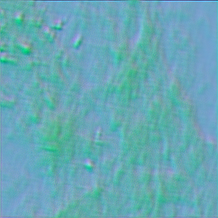

In [290]:
class ColorizerModel(nn.Module):
    def __init__(self, k=5, n=3):
        super().__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        layers = [nn.Conv2d(1, 3, (k,k), padding=1)]
        for x in range(n-1):
            layers.append(nn.Conv2d(3, 3, (k,k), padding=1))
        self.conv = nn.Sequential(*layers)
        #self.conv2 = nn.Conv2d(3, 3, (k,k), padding=1)
        #self.conv3 = nn.Conv2d(3, 3, (k,k), padding=1)
        #self.conv4 = nn.Conv2d(3, 3, (k,k), padding=1)
        
    def forward(self, bwImage):
        # model basically uses 3 convolutional filters to add residual color information on top of original image
        rgbBase = torch.cat([bwImage,bwImage,bwImage], dim=1)
        print(bwImage.shape, rgbBase.shape)
        C = self.conv(bwImage)
        #for x in range(len(self.convs))
        #C = self.conv2(C)
        #C = self.conv3(C)
        #C = self.conv4(C)
        print('C', C.shape)
        return rgbBase, C

        
        
model = ColorizerModel()
tensors = torch.stack([tensor]*8)
print('tensors', tensors.shape)
rgb, res = model(tensors)
print(rgb.shape, res.shape, rgb.min(), rgb.mean(), rgb.max())


backToPil(res[2].detach())

In [271]:
model.state_dict

<bound method Module.state_dict of ColorizerModel(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  )
)>

tensors torch.Size([8, 1, 224, 224])
torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 224, 224]) tensor(-2.1565, grad_fn=<MinBackward1>) tensor(-0.7514, grad_fn=<MeanBackward0>) tensor(1.6640, grad_fn=<MaxBackward1>)
torch.Size([3, 224, 224])
(224, 224, 3) 0 93.28470450680273 255 uint8


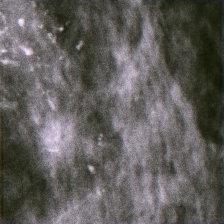

In [307]:
class ColorizerModel(nn.Module):
    def __init__(self, k=5, n=3):
        super().__init__()
        assert n>=1
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        layers = [nn.Conv2d(1, 3, (k, k), padding='same')]
        for x in range(n - 1):
            layers.append(nn.Conv2d(3, 3, (k, k), padding='same'))
        self.conv = nn.Sequential(*layers)

    def forward(self, bwImage):
        # model basically uses 3 convolutional filters to add residual color information on top of original image
        rgbBase = torch.cat([bwImage, bwImage, bwImage], dim=1)
        C = self.conv(bwImage)
        #return rgbBase, C
        print(rgbBase.shape, C.shape)
        return rgbBase + C

    
model = ColorizerModel()
tensors = torch.stack([tensor]*8)
print('tensors', tensors.shape)
res = model(tensors)
print(res.shape, res.shape, res.min(), res.mean(), res.max())


backToPil(res[2].detach())

tensors torch.Size([8, 1, 224, 224])
torch.Size([8, 1, 224, 224]) torch.Size([8, 3, 224, 224])
C torch.Size([8, 3, 216, 216])
torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 216, 216]) tensor(-1.8275) tensor(-0.6825) tensor(1.5137)
torch.Size([3, 216, 216])
(216, 216, 3) 0 99.49963563100137 255 uint8


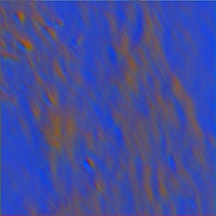

In [265]:
class ColorizerModel(nn.Module):
    def __init__(self, k=5):
        super().__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        self.conv = nn.Conv2d(1, 3, (k,k), padding=1)
        self.conv2 = nn.Conv2d(3, 3, (k,k), padding=1)
        self.conv3 = nn.Conv2d(3, 3, (k,k), padding=1)
        self.conv4 = nn.Conv2d(3, 3, (k,k), padding=1)
        
    def forward(self, bwImage):
        # model basically uses 3 convolutional filters to add residual color information on top of original image
        rgbBase = torch.cat([bwImage,bwImage,bwImage], dim=1)
        print(bwImage.shape, rgbBase.shape)
        C = self.conv(bwImage)
        C = self.conv2(C)
        C = self.conv3(C)
        C = self.conv4(C)
        print('C', C.shape)
        return rgbBase, C

        
        
model = ColorizerModel()
tensors = torch.stack([tensor]*8)
print('tensors', tensors.shape)
rgb, res = model(tensors)
print(rgb.shape, res.shape, rgb.min(), rgb.mean(), rgb.max())


backToPil(res[2].detach())

(224, 224, 3) 0 86.88426737882654 255


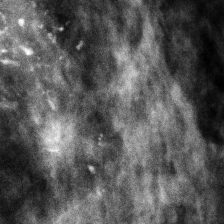

In [147]:
backToPil(rgb[2].detach())

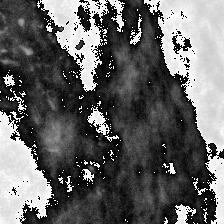

In [77]:
invTrans = [
    #T.Normalize(mean = [ -0.5, -0.5, -0.5 ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    T.Normalize(mean = [ 0.5*255, 0.5*255, 0.5*255 ], std = [ 1/0.25, 1/0.25, 1/0.25 ]),
    #T.Normalize(mean = [ -0.5, -0.5, -0.5 ])
    T.ToPILImage()
]
invTrans = T.Compose(invTrans)
pilb = invTrans(rgb[0])
pilb

In [70]:
ab=np.asarray(pilb)
ab.min(), ab.mean(), ab.max(), a.std()

(0, 99.19610969387755, 255, 35.889364616424196)

torch.Size([3, 224, 224])
(224, 224, 3) 0 86.88426737882654 255


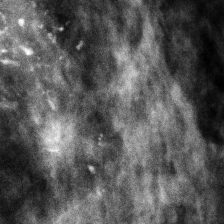

In [113]:
print(rgb[0].shape)
backToPil(rgb[0])


In [ ]:
rgb.()

In [29]:
rgb.max()

tensor(0.1961)

In [26]:
255*((rgb-rgb.min())/rgb.max()).max()

tensor(2112.8564)

In [28]:
(rgb*255).max()

tensor(50.0000)

tensors torch.Size([8, 1, 224, 224])
rgb -1.7490196228027344 -0.4385053813457489 1.5137255191802979
C -1.4521068334579468 -0.06157425418496132 1.2550861835479736
torch.Size([8, 3, 56, 56]) tensor(-0.9956, grad_fn=<MinBackward1>) tensor(-0.2879, grad_fn=<MeanBackward0>) tensor(0.9641, grad_fn=<MaxBackward1>)
torch.Size([3, 56, 56])
(56, 56, 3) 0 91.5845025510204 255 uint8


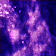

In [191]:
import torch.nn.functional as F

class PoolingColorizer(nn.Module):
    def __init__(self, k=7, f=8):
        super().__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

        # first stage at 224 image size
        layers = [
            nn.Conv2d(1, f, (k, k), padding='same'),
            nn.ReLU(),
            nn.Conv2d(f, f, (k, k), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        ]

        # second stage at 112 tensor size
        f2 = 2*f
        layers += [
            nn.Conv2d(f, f2, (k, k), padding='same'),
            nn.ReLU(),
            nn.Conv2d(f2, f2, (k, k), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        ]

        # third stage, 56x56
        # finally we map channels to 3 colors with depthwise kernels ...
        # tanh activation here might make things easier to normalize layer?
        layers += [
            nn.Conv2d(f2, 3, (1, 1), padding='same'),
            #nn.Tanh()
        ]

        #for x in range(n - 1):
        self.conv = nn.Sequential(*layers)

    def forward(self, bwImage):
        # model basically uses 3 convolutional filters to add residual color information on top of original image
        downSized = F.max_pool2d(bwImage, 4)
        rgbBase = torch.cat([downSized, downSized, downSized], dim=1)

        C = self.conv(bwImage)
        #return rgbBase, C
        #print(rgbBase.shape, C.shape)
        print(f'rgb {rgbBase.min()} {rgbBase.mean()} {rgbBase.max()}')
        C = 10*C
        print(f'C {C.min()} {C.mean()} {C.max()}')
        out = C + rgbBase
        out = torch.tanh(out)
        return out



    
model = PoolingColorizer()
tensors = torch.stack([tensor]*8)
print('tensors', tensors.shape)
rgb = model(tensors)
print(rgb.shape, rgb.min(), rgb.mean(), rgb.max())


backToPil(rgb[2].detach())

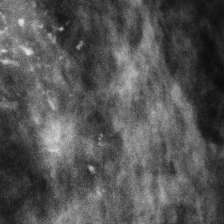

In [22]:
pil